In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = '/content/drive/MyDrive/CustomData/beer_reviews.csv'

In [4]:
# Load data
ratings = pd.read_csv(data)
ratings.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [5]:
# Data Cleaning

#remove unecessary features
ratings = ratings.drop(ratings.columns[[1,2,4,5,8,9]],axis=1)

#remove rows with NANs ~4.5% of Data
ratings = ratings.dropna(axis=0)

np.sum(ratings.isna())
ratings.shape
ratings.head()

,brewery_id,review_overall,review_profilename,beer_style,beer_name,beer_abv,beer_beerid
0,10325,1.5,stcules,Hefeweizen,Sausa Weizen,5.0,47986
1,10325,3.0,stcules,English Strong Ale,Red Moon,6.2,48213
2,10325,3.0,stcules,Foreign / Export Stout,Black Horse Black Beer,6.5,48215
3,10325,3.0,stcules,German Pilsener,Sausa Pils,5.0,47969
4,1075,4.0,johnmichaelsen,American Double / Imperial IPA,Cauldron DIPA,7.7,64883


In [6]:
np.sum(ratings.isna())

brewery_id            0
review_overall        0
review_profilename    0
beer_style            0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64

In [7]:
# number of unique instances
n = ratings.nunique(axis=0)
  
print("No.of.unique values in each column :\n",
      n)
ratings.head()

No.of.unique values in each column :
 brewery_id             5232
review_overall           10
review_profilename    32908
beer_style              104
beer_name             44084
beer_abv                530
beer_beerid           49011
dtype: int64


,brewery_id,review_overall,review_profilename,beer_style,beer_name,beer_abv,beer_beerid
0,10325,1.5,stcules,Hefeweizen,Sausa Weizen,5.0,47986
1,10325,3.0,stcules,English Strong Ale,Red Moon,6.2,48213
2,10325,3.0,stcules,Foreign / Export Stout,Black Horse Black Beer,6.5,48215
3,10325,3.0,stcules,German Pilsener,Sausa Pils,5.0,47969
4,1075,4.0,johnmichaelsen,American Double / Imperial IPA,Cauldron DIPA,7.7,64883


In [8]:
# rename columns
ratings = ratings.rename(columns={'brewery_id': 'breweryID','review_profilename':'reviewer','beer_style':'style','beer_name':'beer_name','beer_abv':'ABV','beer_beerid':'beerID'})

#reorder columns
columns_titles = ["reviewer","review_overall","breweryID","style","beer_name","ABV","beerID"]
ratings=ratings.reindex(columns=columns_titles)

ratings.head()

,reviewer,review_overall,breweryID,style,beer_name,ABV,beerID
0,stcules,1.5,10325,Hefeweizen,Sausa Weizen,5.0,47986
1,stcules,3.0,10325,English Strong Ale,Red Moon,6.2,48213
2,stcules,3.0,10325,Foreign / Export Stout,Black Horse Black Beer,6.5,48215
3,stcules,3.0,10325,German Pilsener,Sausa Pils,5.0,47969
4,johnmichaelsen,4.0,1075,American Double / Imperial IPA,Cauldron DIPA,7.7,64883


In [9]:
# Creating Dataset for Collaborative
X = ratings.loc[:,['reviewer','beerID']]
y = ratings.loc[:,'review_overall']

In [10]:
# Creating Dataset for Hybrid
X_h = ratings.loc[:,['reviewer','breweryID','style','ABV','beerID']]
y_h = ratings.loc[:,'review_overall']

In [12]:
X.head()

,reviewer,beerID
0,stcules,47986
1,stcules,48213
2,stcules,48215
3,stcules,47969
4,johnmichaelsen,64883


In [25]:
#Ordinal Encoding
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# Fit the encoder on training data and transform it.  We can also use it to transform test data
ordinal_cols = ['reviewer']
X[ordinal_cols] = enc.fit_transform(X[ordinal_cols])

X.head()
X['reviewer'] = X['reviewer'].astype(int)
X['beerID'] = X['beerID'].astype(int)

#X = X.drop(['breweryID','style','ABV'],axis=1)

In [37]:
X.head()

,reviewer,beerID
0,30121,47986
1,30121,48213
2,30121,48215
3,30121,47969
4,22693,64883


In [26]:
# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

In [27]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [ ]:
X.head()

In [28]:
# Defining Model Architecture
class NNColabFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, embedding_dim_users, embedding_dim_items, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim_items)
        self.fc1 = nn.Linear(embedding_dim_users+embedding_dim_items,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Concatenate user and item embeddings
        embeddings = torch.cat([embedded_users,embedded_items],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds
        

In [29]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [30]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'reviewer'].max()+1
n_items = X.loc[:,'beerID'].max()+1
model = NNColabFiltering(n_users,n_items,embedding_dim_users=50, embedding_dim_items=50, n_activations = 100,rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)


cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)

Epoch 0/9
----------
train loss: 0.6410
val loss: 0.6226
Epoch 1/9
----------
train loss: 0.6199
val loss: 0.6199
Epoch 2/9
----------
train loss: 0.6186
val loss: 0.6191
Epoch 3/9
----------
train loss: 0.6186
val loss: 0.6187
Epoch 4/9
----------
train loss: 0.6184
val loss: 0.6208
Epoch 5/9
----------
train loss: 0.6183
val loss: 0.6194
Epoch 6/9
----------
train loss: 0.6183
val loss: 0.6203
Epoch 7/9
----------
train loss: 0.6183
val loss: 0.6189
Epoch 8/9
----------
train loss: 0.6183
val loss: 0.6210
Epoch 9/9
----------
train loss: 0.6181
val loss: 0.6199
Training complete in 12m 46s


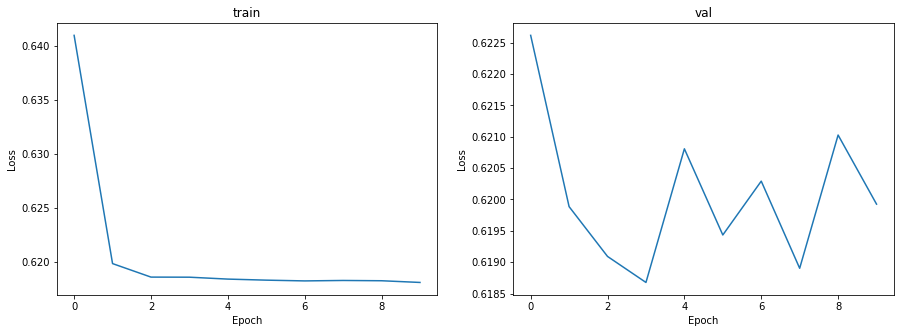

In [31]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

In [32]:
def predict_rating(model,userId,beerId, device):
    # Get predicted rating for a specific user-item pair from model
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([userId, beerId]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

# Get predicted rating for a random user-item pair
rating = predict_rating(model,30121,48215,device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

Predicted rating is 3.1


In [33]:
def generate_recommendations(movies,X,model,userId,device):
    # Get predicted ratings for every movie
    pred_ratings = []
    for movie in movies['beerID'].tolist():
        pred = predict_rating(model,userId,movie,device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    #DATA = movies.iloc[idxs]['beerID'].values.tolist()
    DATA = movies.iloc[idxs]['beerID'].values.tolist()
    # Filter out movies already watched by user
    beers_tasted = X.loc[X['reviewer']==userId, 'beerID'].tolist()
    recs = [rec for rec in DATA if not rec in beers_tasted]
    # Filter to top 10 recommendations
    # Convert movieIDs to titles
    recs_names = []
    for rec in recs:
        recs_names.append(movies.loc[movies['beerID']==rec,'beer_name'].values[0])
    unique_list = []
    # traverse for all elements
    for x in recs_names:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list[:10]

In [ ]:
beer_sub_list = ratings["beer_name"].unique()[:30]
print(beer_sub_list)
subset_rating = ratings[ratings["beer_name"].isin(beer_sub_list)]
print(subset_rating)

In [35]:
# Get recommendations for a random user
userId = 22693
beers = subset_rating
recs = generate_recommendations(beers,X,model,userId,device)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}'.format(i,rec))

Recommendation 0: Caldera IPA
Recommendation 1: Caldera Pale Ale
Recommendation 2: Rauch Ür Bock
Recommendation 3: Dry Hop Red
Recommendation 4: Old Growth Imperial Stout
Recommendation 5: Hopportunity Knocks
Recommendation 6: Caldera Märzen
Recommendation 7: Coconut Porter
Recommendation 8: The Captain's Porter
Recommendation 9: Ashland Amber
